In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES= 2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [1]:

import sys
sys.path.append('keras-deeplab-v3-plus/')
sys.path.append("/home/jimmy15923/models/keras_retinanet")

In [2]:

import sys
sys.path.append('keras-deeplab-v3-plus/')
from deeplab_v3_plus.model import *

import cv2
import numpy as np
import os
import random
from skimage import io
from skimage.transform import resize
from skimage import img_as_bool
import pandas as pd

def read_data_and_split(split_seed, train_ratio, is_normalize=True):
    """read data into np array, normalize it and train test split
    split_seed: set seed for same train test split
    train_ratio: ratio of training set. range from 0 to 1
    is_normalize: True for normalizr to -1 to 1
    
    return np array with x_train, x_test, y_train, y_test
    """
    df = pd.read_csv("/data/jimmy15923/cg_kidney_seg/cgmh_data_list.csv")
    df = df[df.n_mask_pixel > 1000].copy()
    
    idx = df.uid.tolist()
    
#     idx = next(os.walk('/data/jimmy15923/cg_kidney_seg/train'))[1]
#     # remove two file with different size between image & mask
#     idx.remove("S2016-30816_9_0")
#     idx.remove("S2016-30816_9_1")
    
    # set seed
    random.seed(split_seed)
    random.shuffle(idx)
    
    train_idx, test_idx = idx[:int(len(idx)*train_ratio)], idx[int(len(idx)*train_ratio):]

    x_train = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/image/{}_slide.jpg'.format(x, x))[...,::-1]\
                    for x in train_idx], dtype="uint8")
    x_test = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/image/{}_slide.jpg'.format(x, x))[...,::-1]\
                       for x in test_idx], dtype="uint8")
    
    if is_normalize:
        x_train = (x_train / 127.5) - 1
        x_test = (x_test / 127.5) - 1
        
    y_train = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/mask/{}_mask.jpg'.format(x, x))[..., 0]\
                    for x in train_idx])
    
    y_test = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/mask/{}_mask.jpg'.format(x, x))[..., 0]\
                        for x in test_idx])
    
    y_train = y_train.astype(np.bool)
    y_test = y_test.astype(np.bool)
    
    return x_train, x_test, y_train, y_test

def cv2_resize(array, size=500, is_bool=False):
    if is_bool:
        return np.array([img_as_bool(resize(x, (size, size))) for x in array])
    return np.array([resize(x, (size,size), preserve_range=True).astype("uint8") for x in array])

size=500
binarize=False

x_train, x_test, y_train, y_test = read_data_and_split(split_seed=7, train_ratio=0.9, is_normalize=False)

x_train = cv2_resize(x_train, size)
x_test = cv2_resize(x_test, size)
y_train = cv2_resize(y_train, size, is_bool=True)
y_test = cv2_resize(y_test, size, is_bool=True)

if binarize:
    y_train = np.expand_dims(y_train, 3)
    y_test = np.expand_dims(y_test, 3)
else:
    y_train = np.stack((~y_train, y_train), axis=3)
    y_test = np.stack((~y_test, y_test), axis=3)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

import tensorflow as tf
import keras

model = Deeplabv3(input_shape=(size, size, 3), classes=2, OS=8)
logits = model.output
output = keras.layers.Activation("softmax")(logits)
model = Model(model.input, output)


def data_gen(x_train, y_train, bz, augmentation=None):
    from sklearn.utils import shuffle
    x_train, y_train = shuffle(x_train, y_train)
    steps = len(x_train) // bz
    n = 0
    while True:
        if n == steps:
            n=0
            x_train, y_train = shuffle(x_train, y_train)
            
        x, y = x_train[n*bz:(n+1)*bz], y_train[n*bz:(n+1)*bz]
        n+=1

        if augmentation:
            import imgaug
            # Augmentors that are safe to apply to masks
            # Some, such as Affine, have settings that make them unsafe, so always
            # test your augmentation on masks
            MASK_AUGMENTERS = ["Sequential", "SomeOf", "OneOf", "Sometimes",
                               "Fliplr", "Flipud", "CropAndPad",
                               "Affine", "PiecewiseAffine"]
            
            def hook(images, augmenter, parents, default):
                """Determines which augmenters to apply to masks."""
                return (augmenter.__class__.__name__ in MASK_AUGMENTERS)

            # Make augmenters deterministic to apply similarly to images and masks
            det = augmentation.to_deterministic()
            x = det.augment_images(x)
            # Change mask to np.uint8 because imgaug doesn't support np.bool
            y = det.augment_images(y.astype(np.uint8),
                                     hooks=imgaug.HooksImages(activator=hook))
            x = (x / 127.5) - 1
            
        yield x, y

from imgaug import augmenters as iaa
model.compile(optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9, nesterov=True),
              loss='categorical_crossentropy')

early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, verbose=1)
check = keras.callbacks.ModelCheckpoint(monitor="val_loss",
                                        filepath="/data/jimmy15923/cg_kidney_seg/deeplab_resize_aug.h5",
                                        verbose=1, save_best_only=True)

reduce = keras.callbacks.ReduceLROnPlateau(patience=3)

augmentation = iaa.SomeOf((0, 4), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 5.0)),
        iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
        iaa.AddToHueAndSaturation()
    ])

# # gpu_check = MutliGPU_ModelCheckpoint(model, "/data/jimmy15923/deepx_resize_aug.h5")
# model.fit_generator(data_gen(x_train, y_train, 12, augmentation),
#                     steps_per_epoch=100,
#                     epochs=1000, 
#                     validation_data=(x_test, y_test),
#                     callbacks=[early, check, reduce]
#                    )

Using TensorFlow backend.
/home/jimmy15923/.conda/envs/tf18_keras/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/jimmy15923/.conda/envs/tf18_keras/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/jimmy15923/.conda/envs/tf18_keras/lib/python3.6/site-packages/skimage/util/dtype.py:126: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  .format(dtypeobj_in, dtypeobj_out))
/home/jimmy15923/.conda/envs/tf18_keras/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to bool
  .

(800, 500, 500, 3)
(89, 500, 500, 3)
(800, 500, 500, 2)
(89, 500, 500, 2)


In [3]:
from deeplab_v3_plus.model import *

In [217]:
import glob
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.cross_validation import train_test_split
import random
import keras
from keras import backend as K
from keras.utils import to_categorical
from keras.utils.training_utils import multi_gpu_model
from keras.models import load_model
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5"

import tensorflow as tf
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

import sys
sys.path.append('keras-deeplab-v3-plus/')
from deeplab_v3_plus.model import *

import cv2
import numpy as np
import os
import random
from skimage import io
from skimage.transform import resize
from skimage import img_as_bool

def read_data_and_split(split_seed, train_ratio, is_normalize=True):
    """read data into np array, normalize it and train test split
    split_seed: set seed for same train test split
    train_ratio: ratio of training set. range from 0 to 1
    is_normalize: True for normalizr to -1 to 1
    
    return np array with x_train, x_test, y_train, y_test
    """
    df = pd.read_csv("/data/jimmy15923/cg_kidney_seg/cgmh_data_list.csv")
    df = df[df.n_mask_pixel > 1000].copy()
    
    idx = df.uid.tolist()
    
#     idx = next(os.walk('/data/jimmy15923/cg_kidney_seg/train'))[1]
#     # remove two file with different size between image & mask
#     idx.remove("S2016-30816_9_0")
#     idx.remove("S2016-30816_9_1")
    
    # set seed
    random.seed(split_seed)
    random.shuffle(idx)
    
    train_idx, test_idx = idx[:int(len(idx)*train_ratio)], idx[int(len(idx)*train_ratio):]

    x_train = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/image/{}_slide.jpg'.format(x, x))[...,::-1]\
                    for x in train_idx], dtype="uint8")
    x_test = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/image/{}_slide.jpg'.format(x, x))[...,::-1]\
                       for x in test_idx], dtype="uint8")
    
    if is_normalize:
        x_train = (x_train / 127.5) - 1
        x_test = (x_test / 127.5) - 1
        
    y_train = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/mask/{}_mask.jpg'.format(x, x))[..., 0]\
                    for x in train_idx])
    
    y_test = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/mask/{}_mask.jpg'.format(x, x))[..., 0]\
                        for x in test_idx])
    
    y_train = y_train.astype(np.bool)
    y_test = y_test.astype(np.bool)
    
    return x_train, x_test, y_train, y_test

def cv2_resize(array, size=500, is_bool=False):
    if is_bool:
        return np.array([img_as_bool(resize(x, (size, size))) for x in array])
    return np.array([resize(x, (size,size), preserve_range=True).astype("uint8") for x in array])

size=250
binarize=False

x_train, x_test, y_train, y_test = read_data_and_split(split_seed=7, train_ratio=0.9, is_normalize=False)

x_train = cv2_resize(x_train, size)
x_test = cv2_resize(x_test, size)
y_train = cv2_resize(y_train, size, is_bool=True)
y_test = cv2_resize(y_test, size, is_bool=True)

if binarize:
    y_train = np.expand_dims(y_train, 3)
    y_test = np.expand_dims(y_test, 3)
else:
    y_train = np.stack((~y_train, y_train), axis=3)
    y_test = np.stack((~y_test, y_test), axis=3)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


def data_gen(x_train, y_train, bz, augmentation=None):
    from sklearn.utils import shuffle
    x_train, y_train = shuffle(x_train, y_train)
    steps = len(x_train) // bz
    n = 0
    while True:
        if n > steps:
            n=0
            x_train, y_train = shuffle(x_train, y_train)
            
        x, y = x_train[n*bz:(n+1)*bz], y_train[n*bz:(n+1)*bz]
        n+=1

        if augmentation:
            import imgaug
            # Augmentors that are safe to apply to masks
            # Some, such as Affine, have settings that make them unsafe, so always
            # test your augmentation on masks
            MASK_AUGMENTERS = ["Sequential", "SomeOf", "OneOf", "Sometimes",
                               "Fliplr", "Flipud", "CropAndPad",
                               "Affine", "PiecewiseAffine"]
            
            def hook(images, augmenter, parents, default):
                """Determines which augmenters to apply to masks."""
                return (augmenter.__class__.__name__ in MASK_AUGMENTERS)

            # Make augmenters deterministic to apply similarly to images and masks
            det = augmentation.to_deterministic()
            x = det.augment_images(x)
            # Change mask to np.uint8 because imgaug doesn't support np.bool
            y = det.augment_images(y.astype(np.uint8),
                                     hooks=imgaug.HooksImages(activator=hook))

        yield x, y

from imgaug import augmenters as iaa


augmentation = iaa.SomeOf((0, 5), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
#         iaa.Multiply((0.8, 1.5)),
#         iaa.GaussianBlur(sigma=(0.0, 5.0)),
#         iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
#         iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0))
    ])



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5954299262006562467
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10915158426
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9635286840199742524
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:0d:00.0, compute capability: 6.1"
]


/home/jimmy15923/.conda/envs/tf18_keras/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/jimmy15923/.conda/envs/tf18_keras/lib/python3.6/site-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  .format(dtypeobj_in, dtypeobj_out))
/home/jimmy15923/.conda/envs/tf18_keras/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to bool
  .format(dtypeobj_in, dtypeobj_out))


(800, 250, 250, 3)
(89, 250, 250, 3)
(800, 250, 250, 2)
(89, 250, 250, 2)


In [499]:
def data_gen(x_train, y_train, bz, augmentation=None):
    from sklearn.utils import shuffle
    x_train, y_train = shuffle(x_train, y_train)
    steps = len(x_train) // bz
    n = 0
    while True:
        if n >= steps:
            n=0
            x_train, y_train = shuffle(x_train, y_train)
            
        x, y = x_train[n*bz:(n+1)*bz], y_train[n*bz:(n+1)*bz]
        print(n)
        n+=1

        if augmentation:
            import imgaug
            # Augmentors that are safe to apply to masks
            # Some, such as Affine, have settings that make them unsafe, so always
            # test your augmentation on masks
            MASK_AUGMENTERS = ["Sequential", "SomeOf", "OneOf", "Sometimes",
                               "Fliplr", "Flipud", "CropAndPad",
                               "Affine", "PiecewiseAffine"]
            
            def hook(images, augmenter, parents, default):
                """Determines which augmenters to apply to masks."""
                return (augmenter.__class__.__name__ in MASK_AUGMENTERS)

            # Make augmenters deterministic to apply similarly to images and masks
            det = augmentation.to_deterministic()
            x = det.augment_images(x)
            # Change mask to np.uint8 because imgaug doesn't support np.bool
            y = det.augment_images(y.astype(np.uint8),
                                     hooks=imgaug.HooksImages(activator=hook))
            x = (x / 127.5) - 1

        yield x, y

# from imgaug import augmenters as iaa
# model_gpu.compile(optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9, nesterov=True),
#               loss='categorical_crossentropy')

# early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, verbose=1)
# check = keras.callbacks.ModelCheckpoint(monitor="val_loss",
#                                         filepath="/data/jimmy15923/cg_kidney_seg/deepx_resize_aug.h5",
#                                         verbose=1, save_best_only=True)

# reduce = keras.callbacks.ReduceLROnPlateau(patience=3)

augmentation = iaa.SomeOf((0, 4), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.GaussianBlur(sigma=(0.0, 1.5)),
        iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),
        iaa.Add((-10, 10), per_channel=0.5),
        iaa.AddToHueAndSaturation()
    ])



In [500]:
traingen = data_gen(x_train, y_train, bz=8, augmentation=augmentation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


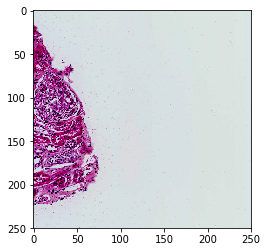

In [503]:
plt.imshow(x[2])

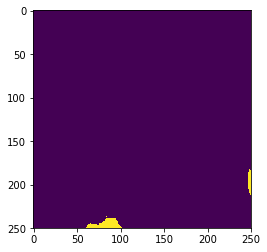

In [359]:
plt.imshow(y[2][:,:,1])

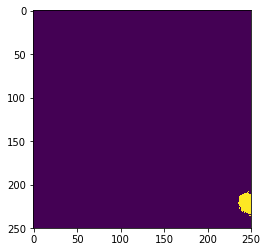

In [85]:
plt.imshow(y_train[0][:,:,1])

In [ ]:
import glob
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.cross_validation import train_test_split
import random
from keras import backend as K
import keras
from keras.utils import to_categorical
from keras.utils.training_utils import multi_gpu_model
from keras.models import load_model

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

import os
import tensorflow as tf
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

import sys
sys.path.append('keras-deeplab-v3-plus/')
from deeplab_v3_plus.model import *

import cv2
import numpy as np
import os
import random
from skimage import io
from skimage.transform import resize
from skimage import img_as_bool

def read_data_and_split(split_seed, train_ratio, is_normalize=True):
    """read data into np array, normalize it and train test split
    split_seed: set seed for same train test split
    train_ratio: ratio of training set. range from 0 to 1
    is_normalize: True for normalizr to -1 to 1
    
    return np array with x_train, x_test, y_train, y_test
    """
    df = pd.read_csv("/data/jimmy15923/cg_kidney_seg/cgmh_data_list.csv")
    df = df[df.n_mask_pixel > 1000].copy()
    
    idx = df.uid.tolist()
    
#     idx = next(os.walk('/data/jimmy15923/cg_kidney_seg/train'))[1]
#     # remove two file with different size between image & mask
#     idx.remove("S2016-30816_9_0")
#     idx.remove("S2016-30816_9_1")
    
    # set seed
    random.seed(split_seed)
    random.shuffle(idx)
    
    train_idx, test_idx = idx[:int(len(idx)*train_ratio)], idx[int(len(idx)*train_ratio):]

    x_train = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/image/{}_slide.jpg'.format(x, x))[...,::-1]\
                    for x in train_idx], dtype="float32")
    x_test = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/image/{}_slide.jpg'.format(x, x))[...,::-1]\
                       for x in test_idx], dtype="float32")
    
    if is_normalize:
        x_train = (x_train / 127.5) - 1
        x_test = (x_test / 127.5) - 1
        
    y_train = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/mask/{}_mask.jpg'.format(x, x))[..., 0]\
                    for x in train_idx])
    
    y_test = np.array([cv2.imread('/data/jimmy15923/cg_kidney_seg/train/{}/mask/{}_mask.jpg'.format(x, x))[..., 0]\
                        for x in test_idx])
    
    y_train = y_train.astype(np.bool)
    y_test = y_test.astype(np.bool)
    
    return x_train, x_test, y_train, y_test

def cv2_resize(array, size=500, is_bool=False):
    if is_bool:
        return np.array([img_as_bool(resize(x, (size, size))) for x in array])
    return np.array([resize(x, (size,size)) for x in array])

size=500
binarize=False
x_train, x_test, y_train, y_test = read_data_and_split(split_seed=7, train_ratio=0.9, is_normalize=True)

x_train = cv2_resize(x_train, size)
x_test = cv2_resize(x_test, size)
y_train = cv2_resize(y_train, size, is_bool=True)
y_test = cv2_resize(y_test, size, is_bool=True)

if binarize:
    y_train = np.expand_dims(y_train, 3)
    y_test = np.expand_dims(y_test, 3)
else:
    y_train = np.stack((~y_train, y_train), axis=3)
    y_test = np.stack((~y_test, y_test), axis=3)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
import tensorflow as tf

model = Deeplabv3(input_shape=(size, size, 3), classes=2, OS=8)
logits = model.output
output = keras.layers.Activation("softmax")(logits)
model = Model(model.input, output)


def data_gen(x_train, y_train, bz, augmentation=None):
    from sklearn.utils import shuffle
    x_train, y_train = shuffle(x_train, y_train)
    steps = len(x_train) // bz
    n = 0
    while True:
        if n >= steps:
            n=0
            x_train, y_train = shuffle(x_train, y_train)
            
        x, y = x_train[n*bz:(n+1)*bz], y_train[n*bz:(n+1)*bz]
        n+=1

        if augmentation:
            import imgaug
            # Augmentors that are safe to apply to masks
            # Some, such as Affine, have settings that make them unsafe, so always
            # test your augmentation on masks
            MASK_AUGMENTERS = ["Sequential", "SomeOf", "OneOf", "Sometimes",
                               "Fliplr", "Flipud", "CropAndPad",
                               "Affine", "PiecewiseAffine"]
            
            def hook(images, augmenter, parents, default):
                """Determines which augmenters to apply to masks."""
                return (augmenter.__class__.__name__ in MASK_AUGMENTERS)

            # Make augmenters deterministic to apply similarly to images and masks
            det = augmentation.to_deterministic()
            x = det.augment_images(x)
            # Change mask to np.uint8 because imgaug doesn't support np.bool
            y = det.augment_images(y.astype(np.uint8),
                                     hooks=imgaug.HooksImages(activator=hook))

        yield x, y

from imgaug import augmenters as iaa
model.compile(optimizer=keras.optimizers.SGD(lr=1e-5, momentum=0.9, nesterov=True),
              loss='categorical_crossentropy')

early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, verbose=1)
check = keras.callbacks.ModelCheckpoint(monitor="val_loss",
                                        filepath="/data/jimmy15923/cg_kidney_seg/deepx_resize_aug.h5",
                                        verbose=1, save_best_only=True)

reduce = keras.callbacks.ReduceLROnPlateau(patience=3)

augmentation = iaa.SomeOf((0, 4), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Multiply((0.8, 1.5)),
        iaa.GaussianBlur(sigma=(0.0, 5.0)),
        iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),
        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0))
    ])

# gpu_check = MutliGPU_ModelCheckpoint(model, "/data/jimmy15923/deepx_resize_aug.h5")
model.fit_generator(data_gen(x_train, y_train, 8, augmentation),
                    steps_per_epoch=200,
                    epochs=1000, 
                    validation_data=(x_test, y_test)
#                     callbacks=[early, gpu_check, reduce]
                   )

In [4]:
size = 512
model = Deeplabv3(input_shape=(size, size, 3), classes=2, OS=8)
logits = model.output
output = keras.layers.Activation("softmax")(logits)
model = Model(model.input, output)

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 256, 256, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
Conv_BN (BatchNormalization)    (None, 256, 256, 32) 128         Conv[0][0]                       
__________________________________________________________________________________________________
Conv_Relu6 (Activation)         (None, 256, 256, 32) 0           Conv_BN[0][0]                    
__________________________________________________________________________________________________
expanded_c

In [ ]:
y_pred = model_gpu.predict(x_test)

In [ ]:
def IOU_cal(y_true, y_pred):
    iou_res = []
    for i in range(len(y_true)):
        y_true_flat = y_true[i].ravel()
        y_pred_flat = (y_pred[i][:,:,0].ravel() > 0.5) * 1
        intersection = abs(y_true_flat * y_pred_flat).sum()
        union = y_true_flat.sum() + y_pred_flat.sum()
        iou = 2* intersection / union
        iou_res.append(iou)
    return iou_res

In [ ]:
def IOU(y_true, y_pred, epsilon=1e-6):
    y_pred = y_pred[:,:,:,1]
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * np.sum(y_pred * y_true, axes)
    denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)
    
    return 1 - np.mean(numerator / (denominator + epsilon))

In [ ]:
re = IOU_cal(y_test, y_pred)
re2 = IOU(y_test, y_pred)

In [ ]:
def data_gen(x_train, y_train, bz, augmentation=None):
    from sklearn.utils import shuffle
    x_train, y_train = shuffle(x_train, y_train)
    steps = len(x_train) // bz
    n = 0
    while True:
        if n > steps:
            n=0
            x_train, y_train = shuffle(x_train, y_train)
            
        x, y = x_train[n*bz:(n+1)*bz], y_train[n*bz:(n+1)*bz]
        n+=1

        if augmentation:
            import imgaug
            # Augmentors that are safe to apply to masks
            # Some, such as Affine, have settings that make them unsafe, so always
            # test your augmentation on masks
            MASK_AUGMENTERS = ["Sequential", "SomeOf", "OneOf", "Sometimes",
                               "Fliplr", "Flipud", "CropAndPad",
                               "Affine", "PiecewiseAffine"]

            def hook(images, augmenter, parents, default):
                """Determines which augmenters to apply to masks."""
                return (augmenter.__class__.__name__ in MASK_AUGMENTERS)

            # Make augmenters deterministic to apply similarly to images and masks
            det = augmentation.to_deterministic()
            x = det.augment_images(x)
            # Change mask to np.uint8 because imgaug doesn't support np.bool
            y = det.augment_images(y.astype(np.uint8),
                                     hooks=imgaug.HooksImages(activator=hook))

        yield x, y

In [ ]:
x, y = next(data_gen(x_train, y_train, bz=8))

In [ ]:
plt.imshow(x[0])

In [ ]:
np.unique(y[0])

In [ ]:
plt.imshow(y[0])

In [ ]:
re2

In [ ]:
re

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 30, 10
idx = np.random.choice(len(y_pred))
print(idx)
idx=2
plt.subplot(131)
plt.title("y_pred")
plt.imshow((y_pred[idx][:,:,1] > 0.5) * 1)
plt.subplot(132)
plt.title("y_test")
plt.imshow(y_test[idx])
plt.subplot(133)
plt.title("ori")
plt.imshow(x_test_plot[idx])